**Kaggle team name**: 🐧1-Hodl-Bollineni,Cahill,Rivas 
1. Format: `🐧[BB Team#]-[Your fancy Kaggle group name]-[Students' names]`. 
  1. Eg. `🐧A-Heros-Fleischer,Melnikov`, where 🐧 identifies JHU and `A` identifies the Canvas group code

Your private LB score must be reproducible with this Colab. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation). Don't exceed runtime quota.

<small><hr style="margin:0;background-color:silver"><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, ©<a href="https://apps.ep.jhu.edu/course-homepages/3765-605-742-deep-neural-networks" target="_blank">JHU</a> 2021 onwards</font></small>

<hr color=red>

# **🏆📈Crypto**


<details><summary><font color=darkblue>More info and Kaggle API instructions</font></summary>

[Kaggle competition URL](https://www.kaggle.com/competitions/4422crypto/rules). See competition rules, submission, grading, dataset, and performance metric. The **starter code** below produces a baseline model, which you should beat, while respecting the competition rules. Your code starts after the timer. This is your baseline model. Seed all [RNG](https://en.wikipedia.org/wiki/Random_number_generation) for reproducibility!

**Instructions for enabling Kaggle API in Colab**:
1. Accept competition rules before running [Kaggle API](https://github.com/Kaggle/kaggle-api#api-credentials). [Loading Kaggle dataset example](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab)
1. In your Kaggle Account, [Create API Token](https://github.com/Kaggle/kaggle-api#api-credentials) and save the resulting **kaggle.json** file to the [root of your Google Drive](https://drive.google.com/drive/u/0/my-drive) 
2. In Colab, open **Files** panel 🗀 (on the left) and click gray folder icon <font color=gray>🖿</font> to mount your Google drive

Your Kaggle/Google Drive credentials are secure; and Colab's kaggle.json only lasts a Colab session.

</details>

## **Starter code (do not modify)**

In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install tensorflow==2.8 > log
!apt -q install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 >> log
!pip -q install -U tfds-nightly tensorflow_addons tensorflow >> log

In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                               # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log       # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                  # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v 4422crypto   # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log              # download competition dataset as a zip file
!unzip -o *.zip >> log                            # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show           # print public leaderboard

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: 4422crypto
Using competition: 4422crypto
 teamId  teamName                            submissionDate       score    
-------  ----------------------------------  -------------------  -------  
8994273  Samuel Nathanson                    2022-08-15 00:36:55  0.58318  
8994218  David Na                            2022-08-14 23:43:51  0.48171  
8971975  🐧1-Hodl-Bollineni,Cahill,Riva       2022-08-15 02:07:09  0.47158  
8450081  J10E-TBD-Brodsky,Mendola            2022-04-17 21:29:47  0.43990  
8996485  🐧4-CoinCollector-Nguyen,Cui         2022-08-15 01:41:47  0.40280  
9006339  Naveen Sahi                         2022-08-14 01:16:46  0.39290  
9017049  🐧2-PonziPredictor-Nilla,Rice        2022-08-15 01:42:00  0.36672  
8484625  JD-NFToTheMoon-Hogge-Katsaros       2022-04-18 00:49:12  0.19944  
8985463  carlosrivasJHU                      2022-08-13 00:00:37  0.19682  
8996856  🐧5-TheBeastCoin-Acosta,Yoo  

See [more](https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries) about NVIDIA GPU stats. Test your code in (free) Colab. It uses Tesla K80 GPU.

In [ ]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free,memory.used --format=csv

name, memory.total [MiB], memory.free [MiB], memory.used [MiB]
Tesla T4, 15109 MiB, 15109 MiB, 0 MiB


In [ ]:
!pip -q install -U tensorflow_addons > log   # update tfa in case students need to use it

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, os
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # We load it before tf. Still useless?  https://github.com/tensorflow/tensorflow/issues/38197
import tensorflow_addons as tfa, tensorflow as tf, tensorflow.keras as keras, tensorflow_datasets as tfds
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense, RNN, LSTM, TimeDistributed
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60*5): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=5, suppress=True)
pd.set_option('max_columns', 20, 'precision', 2, 'display.max_rows', 4)

CPU times: user 3.02 s, sys: 443 ms, total: 3.46 s
Wall time: 5.05 s


Your training data are 7 descriptive features for past 500K observations. See helpful [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition).

In [ ]:
tXY = pd.read_csv('tXY.csv', index_col='id'); tXY

,Count,Open,High,Low,Close,Volume,VWAP
id,,,,,,,
0,64,0.20,0.20,0.20,0.20,447,0.20
1,72,0.20,0.20,0.20,0.20,592,0.20
...,...,...,...,...,...,...,...
499998,1636,1.15,1.16,1.15,1.15,2615,1.15
499999,3228,1.13,1.14,1.12,1.13,3354,1.13


Your task is to forecast the closing price for all future time steps (index IDs below).

In [ ]:
pY = pd.read_csv('sampleSubmission.csv', index_col='id'); pY.T

id,500000,500001,500002,500003,500004,500005,500006,500007,500008,500009,...,524421,524422,524423,524424,524425,524426,524427,524428,524429,524430
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tmr = Timer() # runtime limit (in seconds). Add all of your code after the timer

⏳ started. You have 300 sec. Good luck!


<font size=5>⏳</font> <strong><font color=orange size=5>Your Code, Documentation, Ideas and Timer Start Here...</font></strong>


**TODO. Explain your preprocessing:** i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.

We wrote preprocessing algorithm to generate lags over several periods. Lags for a day, a week, a month. We tried first, second and third difference lags as well. We combined these engineered features into one dataframe. The PowerTransformer was used to generate gaussian normal features. We also tried different scalers such as a MinMax scalar and Standard scalar. These either improve the model marginally or didn't improve at all. 
The orignal model did not utilize all of the data. We wanted to try all of the data present so we created a sliding window to create samples of x train and y train dataset. We tried different values for the window. Sampling this was helped our model make significant improvements. Rather than using the same datapoints repeated and sliding down one datapoint, we used all of the 500,000 datapoints.
We did try feature engineering and removed the close price column. However, this did not work and we were losing critical information. We also tried to create new features however we didn't not have enough domain knowledge and our attempts did not improve the pearson correlation.

**TODO. Explain your modeling approach:** ideas you tried and why you thought they would be helpful. Takeaway: how these decisions guided you in modeling.

In our modeling, we used the suggested metrics such as pearson correlation and correlation loss. From this view, we could see the relationship between loss and correlation. We observed that as accuracy increased, so did pearson correlation and loss would decrease. We attetmped to use 1 minus our pearson correlation to use as our loss however the MSE was a better loss function although 1 minus pearson correlation did work well. We also defined a metric for our model to track the pearson correlation. This helped us run our model and check the improvements over epochs but it did not help as an overall metric to use.
We did try to implement a GRU and WaveNet algorithm. We kept getting errors that Colab was out of memory. Our dataset is quite large and the wavenet uses lots of neurons in order to converge to the best model. So, we abandoned this approach and stuck with the LSTM model. We did alter the number of nuerons that the LSTM used, but we could not change the layers since the shape of tensors didn't allow for it based on how we preprocessed the dataset.

This is your baseline DNN model. Remember to [seed all your experiments](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) for reproducibility. [Status of GPU-Determinism in TF](https://github.com/NVIDIA/framework-determinism/blob/master/tensorflow_status.md). 

In [ ]:
len(tXY)/100

5000.0

In [ ]:
from sklearn.preprocessing import PowerTransformer

# Transform our dataset to be more gaussian
gauss_transform = PowerTransformer()
tXY_X = gauss_transform.fit_transform(tXY)
tXY_X = pd.DataFrame(tXY_X)
tXY_X.rename(columns={4:'Close'}, inplace=True)

X_train.shape=(K1,Nx1,p1)=(95, 5000, 7); y_train=(K1,Ny)=(95, 24431)


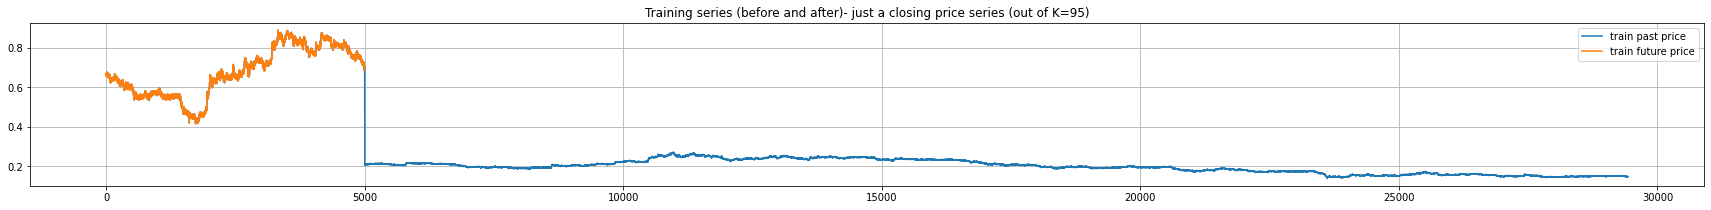

In [ ]:
Nx, Ny = int(len(tXY)/100), len(pY)  # samples, dataset dim, train set size, forecast set size
iters = (len(tXY)-len(pY))/Nx

X_trainL, y_trainL = [], []
for j in range(int(iters)):
  X_trainL.append(tXY_X.iloc[(j*5000):((j*5000)+5000), :].values)
  y_trainL.append(tXY['Close'].iloc[((j*5000)+5000):((j*5000)+5000+Ny)].values)
X_train, y_train = np.array(X_trainL), np.array(y_trainL)
(K1,Nx1,p1), (K1,Ny) = X_train.shape, y_train.shape

print(f'X_train.shape=(K1,Nx1,p1)={X_train.shape}; y_train=(K1,Ny)={y_train.shape}')
df = pd.DataFrame(np.r_[X_train[0,:,4], y_train[0,:]], columns=['train past price'])
ax = df.plot(figsize=(30,3), title=f'Training series (before and after)- just a closing price series (out of K={K1})');
pd.DataFrame(X_train[0,:,4], columns=['train future price']).plot(grid=True, ax=ax);

Build an LSTM model with two hidden layers. It splits $K$ samples into batches with 7D series $X_{N_x\times p}$ as input and 1D series $Y_{N_y\times 1}$ as output.


In [ ]:
from keras import backend as Kb

def pearson_r(y_true, y_pred):
    # use smoothing for not resulting in NaN values
    # pearson correlation coefficient
    # https://github.com/WenYanger/Keras_Metrics
    epsilon = 10e-5
    x = y_true
    y = y_pred
    mx = Kb.mean(x)
    my = Kb.mean(y)
    xm, ym = x - mx, y - my
    r_num = Kb.sum(xm * ym)
    x_square_sum = Kb.sum(xm * xm)
    y_square_sum = Kb.sum(ym * ym)
    r_den = Kb.sqrt(x_square_sum * y_square_sum)
    r = r_num / (r_den + epsilon)
    return Kb.mean(r)

In [ ]:
## Use 1-pearson correlation as the loss function
# def cor_loss(y_true, y_pred):
#   return (1 - pearson_r(y_true, y_pred))

In [ ]:
%%time
tf.random.set_seed(0)   # always seed your experiments
Init = keras.initializers.GlorotUniform(seed=0) # seed all that you can

m = Sequential(
  [LSTM(200, return_sequences=True, input_shape=[None, p1], name='LSTM1', kernel_initializer=Init, recurrent_initializer=Init), 
  Dropout(.15, name='d1'),
  LSTM(200, name='LSTM2', kernel_initializer=Init, recurrent_initializer=Init),
  Dropout(.15, name='d2'),
  Dense(Ny, name='out', kernel_initializer=Init) ], name='RNN_model') # we build Ny forecasts
m.summary()
m.compile(optimizer='adam', loss='mean_squared_error', metrics=[pearson_r])
hist = m.fit(X_train, y_train, epochs=41, batch_size=32)

Model: "RNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, None, 200)         166400    
                                                                 
 d1 (Dropout)                (None, None, 200)         0         
                                                                 
 LSTM2 (LSTM)                (None, 200)               320800    
                                                                 
 d2 (Dropout)                (None, 200)               0         
                                                                 
 out (Dense)                 (None, 24431)             4910631   
                                                                 
Total params: 5,397,831
Trainable params: 5,397,831
Non-trainable params: 0
_________________________________________________________________
Epoch 1/41
3/3 [==============================]

The plot below: the model memorized the prices from recent history (plus some local noise). Still you can use these predictions to visually (i.e. qualitatively) determine whether predictions are meaningful (i.e. have price-like shape) or just noise.

tX_recent.shape=(Nx,p)=(5000, 7)
1/1 [==============================] - 1s 970ms/step


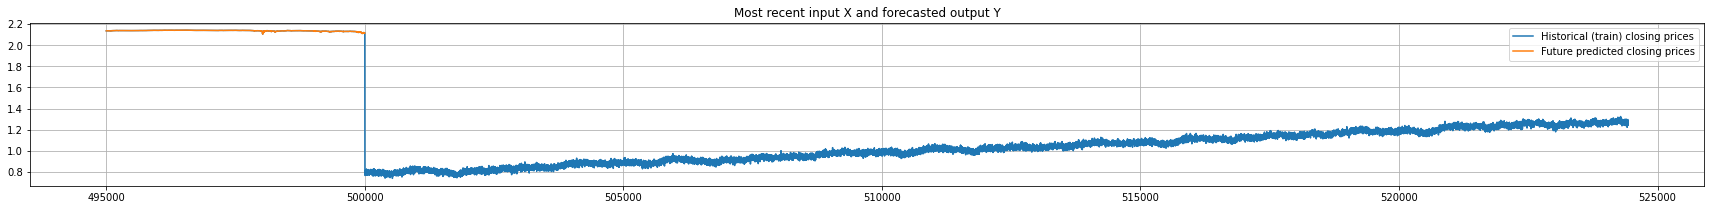

In [ ]:
# tX_recent = tXY_X.iloc[-Nx:,:]  # most recent history of the coin
tX_recent = tXY_X.iloc[-Nx:,:]  # most recent history of the coin
print(f'tX_recent.shape=(Nx,p)={tX_recent.shape}')
pY['Close'] = m.predict(tX_recent.values[np.newaxis,...]).flatten()  # the model expects a 3-tensor (K=1,Nx,p)
ax = pd.concat([tX_recent.Close, pY.Close]).plot(figsize=(30,3), title='Most recent input X and forecasted output Y');
tX_recent.Close.plot(ax=ax, grid=True);
ax.legend(["Historical (train) closing prices", "Future predicted closing prices"]);

1. The model generates a baseline submission CSV file, see Colab folder (🗀 on the left). 
1. You can download the generated CSV file and submit it to Kaggle.

In [ ]:
ToCSV(pY, 'Crypto-baseline')

# **References:**

1. Chen et al. Bitcoin price prediction using machine learning: An approach to sample dimension engineering. Journal of Computational and Applied Mathematics
Volume 365, February 2020, 112395. https://doi.org/10.1016/j.cam.2019.112395

2. Cho et al. Toward Stock Price Prediction using Deep Learning. UCC '19 Companion: Proceedings of the 12th IEEE/ACM International Conference on Utility and Cloud Computing CompanionDecember 2019 Pages 133–135. https://doi.org/10.1145/3368235.3369367

3. "G-Research Crypto Forecasting." Kaggle. Nov 2021 to Feb 2022. https://www.kaggle.com/competitions/g-research-crypto-forecasting/overview/timeline

4. HOML's description of WaveNet, pages 521-523.

5. Pillay, K., Moodley, D. (2022). Exploring Graph Neural Networks for Stock Market Prediction on the JSE. In: Jembere, E., Gerber, A.J., Viriri, S., Pillay, A. (eds) Artificial Intelligence Research. SACAIR 2021. Communications in Computer and Information Science, vol 1551. Springer, Cham. https://doi.org/10.1007/978-3-030-95070-5_7

6. https://discuss.tensorflow.org/t/creating-pearson-correlation-metrics-using-tensorflow-tensor/10333

7. https://github.com/WenYanger/Keras_Metrics

<font size=5>⌛</font> <strong><font color=orange size=5>Do not exceed competition's runtime limit!</font></strong>

<hr color=red>


In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 88 sec


# 💡**Starter Ideas**

1. Try different RNN architectures and hyperparameters
1. Try [correlation loss/metric](https://duckduckgo.com/?q=correlation+loss+in+tensorflow&ia=web) (or equivalent)
1. Try longer/shorter history. FYI: GPU may not fit all observations, but you could lower the precision or simplify DNN
1. Try forecasting returns (differences or log differences at different lags) instead of actual values. Returns might appear "more" stationary (You'll need to compute forecasted prices from forecasted returns later)
1. Try new features: differences, fractions, powers of existing features, lagged features or lagged differences,..
1. Try a different time scale. Eg. forecasting every $k$ steps and then imputing interim values
1. Try technique in HOML pp.509-510
1. Try (programmatically) assigning higher/lower weights to history or historical events (such as extreme events)
1. Check [Kaggle G-Research Crypto Forecasting](https://www.kaggle.com/c/g-research-crypto-forecasting/code) competition for more suitable ideas.
1. Try further smoothing/averaging and forecasting values at sparser intervals
1. Try forecasting just the future trend